In [2]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import dataset
import random

#num of image channel
num_channels = 3
#image size
img_size = 150
# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels
# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)
#convolutional layer 1

filter_size1 = 10
num_filters1 = 128
#convolutional layer 2
filter_size2 = 5
num_filters2 = 64
#convolutional layer 3
filter_size3 = 5
num_filters3 = 32
#convolutional layer 4
filter_size4 = 5
num_filters4 = 32
#convolutional layer 5
filter_size5 = 5
num_filters5 = 32
#fully connected layer
fc_size = 128

# class info
classes = ['ayam_bakar', 'ayam_crispy', 'bakso', 'gado2', 'ikan_bakar', 'mie_goreng', 'nasi_goreng', 'pecel_lele', 'pizza', 'rendang', 'sate', 'soto', 'sushi']
num_classes = len(classes)

# batch size
batch_size = 150

# validation split
validation_size = .25

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = '/home/fatchur/food_images/'
#test_path = '/media/fatchur/F8107C2D107BF0CC/food_images/'

data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
#test_images, test_ids = dataset.read_test_set(test_path, img_size, classes)


print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Reading training images
Loading ayam_bakar files (Index: 0)
/home/fatchur/food_images/ayam_bakar/*.jpg
-------------------------------------------------------------------------------------
Loading ayam_crispy files (Index: 1)/237.jpg(50).jpgg
/home/fatchur/food_images/ayam_crispy/*.jpg
-------------------------------------------------------------------------------------
Loading bakso files (Index: 2)_crispy/osisSMA166.jpgjpg
/home/fatchur/food_images/bakso/*.jpg
-------------------------------------------------------------------------------------
Loading gado2 files (Index: 3)o/237.jpg(50).jpg
/home/fatchur/food_images/gado2/*.jpg
-------------------------------------------------------------------------------------
Loading ikan_bakar files (Index: 4).jpgg
/home/fatchur/food_images/ikan_bakar/*.jpg
-------------------------------------------------------------------------------------
Loading mie_goreng files (Index: 5)r/ikan3 (42).jpgg
/home/fatchur/food_images/mie_goreng/*.jpg
---------

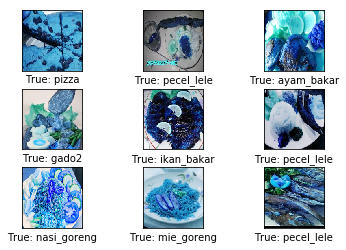

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


# Get some random images and their labels from the train set.
images, cls_true  = data.train.images, data.train.cls
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [4]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
layer_conv4, weights_conv4 = \
    new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)
layer_conv5, weights_conv5 = \
    new_conv_layer(input=layer_conv4,
                   num_input_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv5)
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [5]:
val_acc_val = []
train_acc_val = []
val_loss_val = []

In [6]:
saver = tf.train.Saver()
save_path = 'food_model1/food_model1'
save_path_new = 'food_model_laptop/food_model_laptop'
session = tf.Session()
#session.run(tf.global_variables_initializer())
saver.restore(sess=session, save_path=save_path)
train_batch_size = 25
val_batch_size =25

# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    total_iterations = 0

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_validation_accuracy = 0.63
    best_training_accuracy = 0.55
    best_loss = 122.16
    last_improvement = 0
    require_improvement = num_iterations-1

    for i in range (num_iterations):
        total_iterations += 1
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(val_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(val_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % 1 == 0: 
            # calculate the accuracy of training set
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            # message for printing
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.2%}, Validation Accuracy: {2:>6.2%}, Validation loss: {3:>6.2%} {4}"
            #calculate validation accuracy
            acc_val = session.run(accuracy, feed_dict=feed_dict_validate)
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            
            val_acc_val.append(acc_val)
            train_acc_val.append(acc)
            val_loss_val.append(val_loss)
            
            if (acc_val > best_validation_accuracy) or (acc_val >= best_validation_accuracy and acc >= best_training_accuracy and val_loss < best_loss) or (acc_val >= best_validation_accuracy and acc > best_training_accuracy and val_loss <= best_loss):
                best_validation_accuracy = acc_val
                best_training_accuracy = acc
                best_loss = val_loss
                last_improvement = total_iterations
                saver.save(sess=session, save_path=save_path_new)
                sign = '*'
                # Print it.
                print(msg.format(i, acc, acc_val, val_loss, sign))
            else:
                sign = '-'
                print(msg.format(i, acc, acc_val, val_loss, sign))
    
    
    #update total_iteration
    #total_iterations += num_iterations
  
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [ ]:
optimize(num_iterations=600)

Optimization Iteration:      0, Training Accuracy: 64.00%, Validation Accuracy: 36.00%, Validation loss: 135.40% -
Optimization Iteration:      1, Training Accuracy: 60.00%, Validation Accuracy: 52.00%, Validation loss: 125.23% -
Optimization Iteration:      2, Training Accuracy: 60.00%, Validation Accuracy: 64.00%, Validation loss: 135.40% *
Optimization Iteration:      3, Training Accuracy: 72.00%, Validation Accuracy: 56.00%, Validation loss: 148.25% -
Optimization Iteration:      4, Training Accuracy: 80.00%, Validation Accuracy: 48.00%, Validation loss: 130.65% -
Optimization Iteration:      5, Training Accuracy: 44.00%, Validation Accuracy: 48.00%, Validation loss: 163.85% -
Optimization Iteration:      6, Training Accuracy: 64.00%, Validation Accuracy: 40.00%, Validation loss: 145.60% -
Optimization Iteration:      7, Training Accuracy: 60.00%, Validation Accuracy: 44.00%, Validation loss: 144.37% -
Optimization Iteration:      8, Training Accuracy: 40.00%, Validation Accuracy: 